In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
c = 3e8                              # Speed of light (m/s)
f = 10.5e9                           # Operating frequency (Hz)
Pt = 10e-3                           # Transmitter power (W)
G_dB = 9                             # Antenna gain (dBi)
G = 10**(G_dB/10)                    # Convert dBi to linear scale
Smin_dBm = -60                       # Minimum detectable signal (dBm)
Smin_W = 10**(Smin_dBm/10) / 1000    # Convert dBm to Watts

lambda_ = c / f                      # Wavelength (m)

In [5]:

sigma = np.logspace(-2,2,400)    # Radar cross section (m^2), 400 points from 0.01 to 100

R = ((Pt * G**2 * lambda_**2 * sigma) / ((4 * np.pi)**3 * Smin_W)) ** 0.25 # Radar range equation assuming G for TX/RX


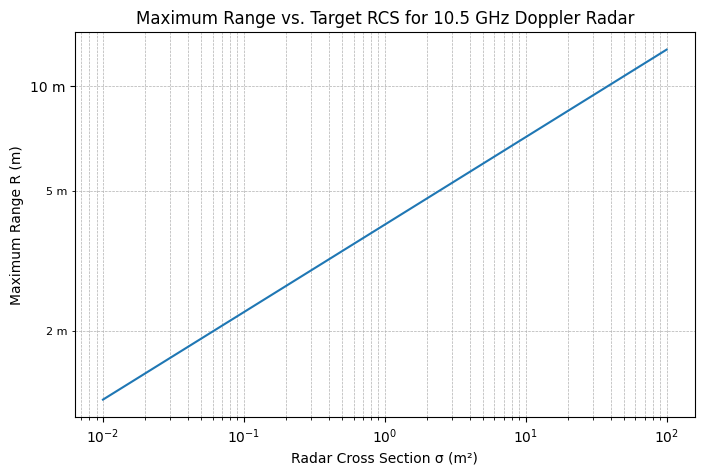

In [ ]:
plt.figure(figsize=(8, 5))
plt.loglog(sigma, R)
plt.xlabel('Radar Cross Section σ (m²)')
plt.ylabel('Maximum Range R (m)')
plt.title('Maximum Range vs. Target RCS for 10.5 GHz Doppler Radar')
ax = plt.gca()
from matplotlib.ticker import FuncFormatter, LogLocator
ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[2,5]))
def meter_formatter(y, pos):
    if y >= 1:
        return f'{y:,.0f} m'
    else:
        return f'{y:.2e} m'
ax.yaxis.set_major_formatter(FuncFormatter(meter_formatter))
ax.yaxis.set_minor_formatter(FuncFormatter(meter_formatter))
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.show()

In [23]:
# clear previous variables
%reset -f

import numpy as np
from scipy.io.wavfile import write

In [26]:
# Radar and simulation parameters

c = 3e8           # Speed of light (m/s)
f = 10.5e9        # Radar frequency (Hz)
lambda_r = c / f  # Wavelength (m)
fs = 8000         # Sampling rate (Hz)
duration = 15     # Duration (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


# Bicycle parameters
sigma_bike = 2
v0_bike = 4.5
a_bike = 0.1

# Car parameters
sigma_car = 100
v0_car = 26.8
a_car = 0.5

In [ ]:
x_bike = 1 + v0_bike * t + 0.5 * a_bike * t**2 # Initial distance + motion
x_car = 1 + v0_car * t + 0.5 * a_car * t**2 # Initial distance + motion

v_bike = v0_bike + a_bike * t # Velocity over time
v_car = v0_car + a_car * t # Velocity over time

fd_bike = 2 * v_bike / lambda_r
fd_car = 2 * v_car / lambda_r

amp_bike = sigma_bike / (x_bike**4) * 1e12
amp_car = sigma_car / (x_car**4) * 1e12

phi_bike = np.cumsum(2 * np.pi * fd_bike / fs)
phi_car = np.cumsum(2 * np.pi * fd_car / fs)

signal = amp_bike * np.sin(phi_bike) + amp_car * np.sin(phi_car) # Combine signals
signal = signal / np.max(np.abs(signal)) # Normalize to -1 to 1

write('radar_signal.wav', fs, (signal * 32767).astype(np.int16))

print(f"Signal length: {len(signal)} samples")
print(f"Expected length: {int(fs * duration)} samples")

print("Number of samples in signal:", len(signal))
print("Duration based on samples:", len(signal) / fs, "seconds")


Signal length: 120000 samples
Expected length: 120000 samples
Number of samples in signal: 120000
Duration based on samples: 15.0 seconds


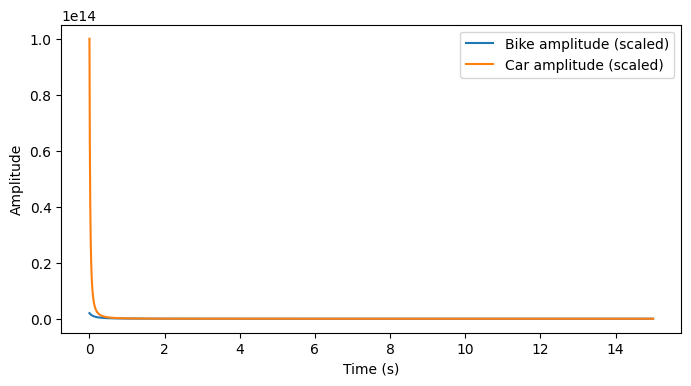

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(t, amp_bike, label="Bike amplitude (scaled)")
plt.plot(t, amp_car, label="Car amplitude (scaled)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [29]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


In [30]:
# Read .wav file
fs, radar_signal = wavfile.read('radar_signal.wav')

# Normalize to float for processing if 16-bit
if radar_signal.dtype == np.int16:
    radar_signal = radar_signal.astype(np.float32) / 32767

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


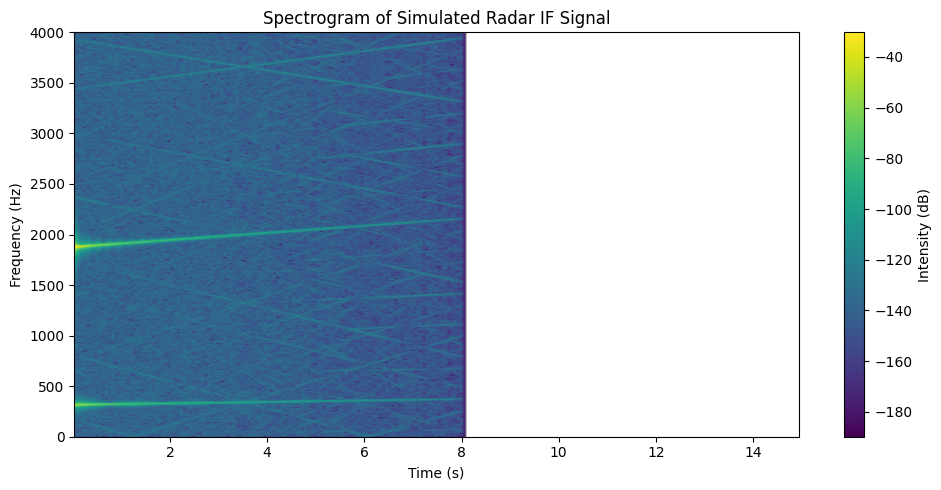

In [31]:
plt.figure(figsize=(10, 5))
plt.specgram(radar_signal, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
plt.title('Spectrogram of Simulated Radar IF Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.tight_layout()
plt.savefig('radar_spectrogram.pdf')   # Save as PDF
plt.show()